## check things

In [ ]:
!nvidia-smi

Wed Jun  5 17:22:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   37C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
conda env list

# conda environments:
#
myenv                    /home/ai4054/.conda/envs/myenv
pim-env               *  /home/ai4054/.conda/envs/pim-env
base                     /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0
netcdf-py39              /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/netcdf-py39
pytorch-2.2.2            /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/pytorch-2.2.2
tensorflow-2.12.1        /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/tensorflow-2.12.1


Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda list

# packages in environment at /home/ai4054/.conda/envs/pim-env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alembic                   1.13.1                   pypi_0    pypi
anyio                     4.3.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hd1e30aa_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge

In [ ]:
import sys
print(sys.executable)

/home/ai4054/.conda/envs/pim-env/bin/python


In [ ]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

pim-env


In [ ]:
import xgboost
import catboost
import imblearn
import lightgbm

# Load data

In [1]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Download dataset
!kaggle competitions download -c forest-type-classification-spai

  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 162MB/s]


In [3]:
!unzip /content/forest-type-classification-spai.zip && rm -rf /content/forest-type-classification-spai.zip

Archive:  /content/forest-type-classification-spai.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import and Visualize data

In [4]:
import os
def create_folders_if_not_exist(*paths):
    for path in paths:
        os.makedirs(path, exist_ok=True)
        print(f"Ensured directory exists: {path}")

# PATH to dataset and to Save the results
data_path = 'dataset'
results_path = 'results/multmodels_optuna/features01-wvote-feat02'
create_folders_if_not_exist(data_path, results_path)

Ensured directory exists: dataset
Ensured directory exists: results/multmodels_optuna/features01-wvote-feat02


In [5]:
data_path = '/content/'
results_path = '/content/' + results_path

In [6]:
import pandas as pd

# Load the training CSV file to check its contents and structure
train_file_path = f'{data_path}/train.csv'
train_df = pd.read_csv(train_file_path)
test_file_path = f'{data_path}/test.csv'
test_df = pd.read_csv(test_file_path)

# Display the first few rows of the training dataframe
train_df.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,2002,293,1927,1038,278,475,453,987,1773,2184,1900,2343,3039,MDF
1,3212,197,1598,697,201,347,228,682,1982,2449,2254,2685,2690,DDF
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,2392,2671,2683,MDF
3,17020,132,1560,689,189,408,175,609,2117,2907,3024,3005,2955,MDF
4,5967,241,1944,1131,362,538,487,918,1549,1844,1702,2077,2043,MDF


## Data Preprocess

In [7]:
# Encode labels to numbers
from sklearn.preprocessing import LabelEncoder

# Fit the label encoder on the original labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df['nforest_type'])

# Print the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original to Encoded):", label_mapping)
y_encoded

Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}


array([2, 0, 2, ..., 0, 2, 2])

In [8]:
from sklearn.decomposition import PCA

def add_features(row) :

    # features01(Jane's features): 17 features
    pca = PCA(n_components=3)
    df_pca = pca.fit_transform(row[['b8_a', 'b6', 'b12', 'b5', 'b11', 'b3', 'b4', 'b1', 'b8', 'b7', 'b2', 'b9']])

    row['NDVI'] = (row['b8'] - row['b4']) / (row['b8'] + row['b4'])
    row['EVI'] = 2.5 * ((row['b8'] - row['b4']) / (row['b8'] + 6 * row['b4'] - 7.5 * row['b2'] + 1.01))
    row['NDWI '] = (row['b3'] - row['b8']) / (row['b3'] + row['b8'])
    row['SAVI '] = (row['b8'] - row['b4']) * (1 + 0.5) / (row['b8'] + row['b4'] + 0.5)
    row['MSAVI'] = (2 * row['b8'] + 1 - ( (2 * row['b8'] + 1) ** 2 - 8 * (row['b8'] - row['b4'])) ** (1 / 2)) / 2
    row['GNDVI '] = (row['b8'] - row['b3']) / (row['b8'] + row['b3'])
    row['RENDVI '] = (row['b8'] - row['b5']) / (row['b8'] + row['b5'])
    row['NDMI '] = (row['b8'] - row['b11']) / (row['b8'] + row['b11'])
    row['GRVI'] = (row['b3'] - row['b4']) / (row['b3'] + row['b4'])
    row['TVI'] = ( (row['b8'] - row['b4']) / (row['b8'] + row['b4'] + 0.5) ) ** (1 / 2)
    row['MCARI'] = ((row['b5'] - row['b4']) - 0.2 * (row['b5'] - row['b3'])) / (row['b5'] / row['b4'])
    row['BSI'] =  ((row['b11'] + row['b4']) - (row['b8'] + row['b2'])) / ((row['b11'] + row['b4']) + (row['b8'] + row['b2']))
    row['NBR'] = (row['b8'] - row['b12']) / (row['b8'] + row['b12'])
    row['MSI'] = row['b11'] / row['b8']
    row['pca1'] = df_pca[:, 0]
    row['pca2'] = df_pca[:, 1]
    row['pca3'] = df_pca[:, 2]

    # features02 (Manotham's features): 9 features
    row['rep'] = 705 + 35 * ((row['b4'] + row['b7']) / 2 - row['b5']) / (row['b6'] - row['b5']) #red edge position
    row['SI'] = (row['b11'] - row['b4']) / (row['b11'] + row['b4']) # Soil indices
    row['BI'] = (row['b4'] + row['b3']) - (row['b5'] + row['b7']) # Soil indices
    row['MNDWI'] = (row['b3'] - row['b11']) / (row['b3'] + row['b11']) # Water indices
    row['MCAR'] = ((row['b5'] - row['b4']) - 0.2 * (row['b5'] - row['b3'])) * (row['b5'] / row['b4']) # New Vegetation Indices
    row['Chlorophyll_Red_Edge'] = (row['b8'] / row['b5']) - 1 # New Vegetation Indices
    row['Brightness_TC'] = 0.3037 * row['b2'] + 0.2793 * row['b3'] + 0.4743 * row['b4'] + 0.5585 * row['b8'] + 0.5082 * row['b11'] + 0.1863 * row['b12'] # Tasseled cap transformations
    row['Greenness_TC'] = -0.2848 * row['b2'] - 0.2435 * row['b3'] - 0.5436 * row['b4'] + 0.7243 * row['b8'] + 0.0840 * row['b11'] - 0.1800 * row['b12']
    row['Wetness_TC'] = 0.1509 * row['b2'] + 0.1973 * row['b3'] + 0.3279 * row['b4'] + 0.3406 * row['b8'] - 0.7112 * row['b11'] - 0.4572 * row['b12']



    return row

train_df_new = add_features(train_df)
test_df_new = add_features(test_df)
train_df_new.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,...,pca3,rep,SI,BI,MNDWI,MCAR,Chlorophyll_Red_Edge,Brightness_TC,Greenness_TC,Wetness_TC
0,2002,293,1927,1038,278,475,453,987,1773,2184,...,-216.061962,719.761450,0.619328,-2243,-0.604496,940.373510,0.925025,2665.7848,910.1103,-913.7096
1,3212,197,1598,697,201,347,228,682,1982,2449,...,24.866739,722.675000,0.750274,-2556,-0.643188,1157.605263,2.304985,2466.9149,1375.6641,-513.8984
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,...,302.257004,722.626354,0.395267,-1765,-0.318865,461.775701,0.960656,3520.8225,719.4804,-431.1658
3,17020,132,1560,689,189,408,175,609,2117,2907,...,90.372846,726.631300,0.798271,-2933,-0.585366,1370.424000,3.965517,2864.4129,1948.9980,-228.1074
4,5967,241,1944,1131,362,538,487,918,1549,1844,...,-421.529957,718.728209,0.599342,-1737,-0.566479,669.178645,0.854031,2640.4000,693.6408,-999.5043


In [9]:
train_df_new['nforest_type']

0        MDF
1        DDF
2        MDF
3        MDF
4        MDF
        ... 
13048    DDF
13049    DDF
13050    DDF
13051    MDF
13052    MDF
Name: nforest_type, Length: 13053, dtype: object

In [10]:
train_df_new.to_csv(f'{results_path}/pim_prepdata_train.csv', index=False)
test_df_new.to_csv(f'{results_path}/pim_prepdata_test.csv', index=False)

In [11]:
#Identify Non-Numeric Columns (should be the labels one ('nforest_type'), we change labels-->numbers)

# Find columns with non-numeric values in train data
non_numeric_columns_train = train_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in train data:", non_numeric_columns_train)

# Find columns with non-numeric values in test data
non_numeric_columns_test = test_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in test data:", non_numeric_columns_test)

Non-numeric columns in train data: Index(['nforest_type'], dtype='object')
Non-numeric columns in test data: Index([], dtype='object')


In [12]:
#Handle Non-Numeric Values
from sklearn.preprocessing import LabelEncoder
train_df_new_num = train_df_new.copy()
test_df_new_num = test_df_new.copy()

# Encode non-numeric values in train data
label_encoders = {}
for col in non_numeric_columns_train:
    le = LabelEncoder()
    train_df_new_num[col] = le.fit_transform(train_df_new_num[col].astype(str))
    label_encoders[col] = le

# Encode non-numeric values in test data using the same encoders
for col in non_numeric_columns_test:
    le = label_encoders.get(col, LabelEncoder())
    test_df_new_num[col] = le.transform(test_df_new_num[col].astype(str)) if col in label_encoders else le.fit_transform(test_df_new_num[col].astype(str))

# Verify the encoding
print(train_df_new_num.head())
print(test_df_new_num.head())

      id   b1   b11   b12   b2    b3   b4    b5    b6    b7  ...        pca3  \
0   2002  293  1927  1038  278   475  453   987  1773  2184  ... -216.061962   
1   3212  197  1598   697  201   347  228   682  1982  2449  ...   24.866739   
2  13312  929  1975  1031  982  1020  856  1220  2051  2421  ...  302.257004   
3  17020  132  1560   689  189   408  175   609  2117  2907  ...   90.372846   
4   5967  241  1944  1131  362   538  487   918  1549  1844  ... -421.529957   

          rep        SI    BI     MNDWI         MCAR  Chlorophyll_Red_Edge  \
0  719.761450  0.619328 -2243 -0.604496   940.373510              0.925025   
1  722.675000  0.750274 -2556 -0.643188  1157.605263              2.304985   
2  722.626354  0.395267 -1765 -0.318865   461.775701              0.960656   
3  726.631300  0.798271 -2933 -0.585366  1370.424000              3.965517   
4  718.728209  0.599342 -1737 -0.566479   669.178645              0.854031   

   Brightness_TC  Greenness_TC  Wetness_TC  
0    

In [13]:
train_df_new_num['nforest_type']

0        2
1        0
2        2
3        2
4        2
        ..
13048    0
13049    0
13050    0
13051    2
13052    2
Name: nforest_type, Length: 13053, dtype: int64

------

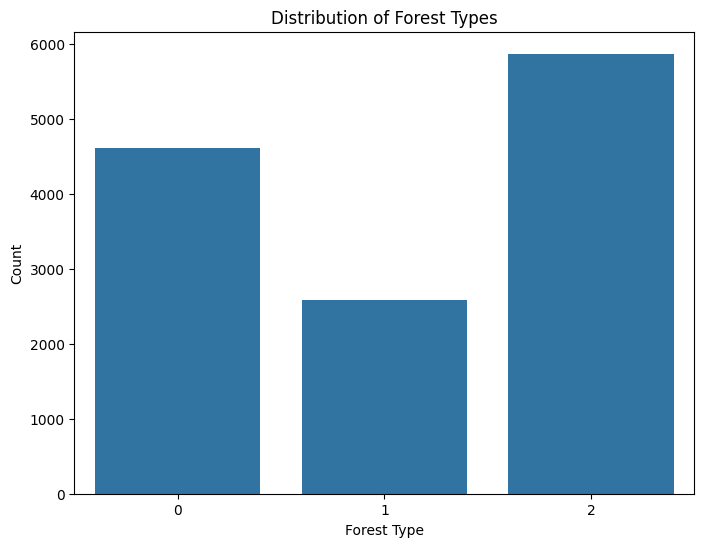

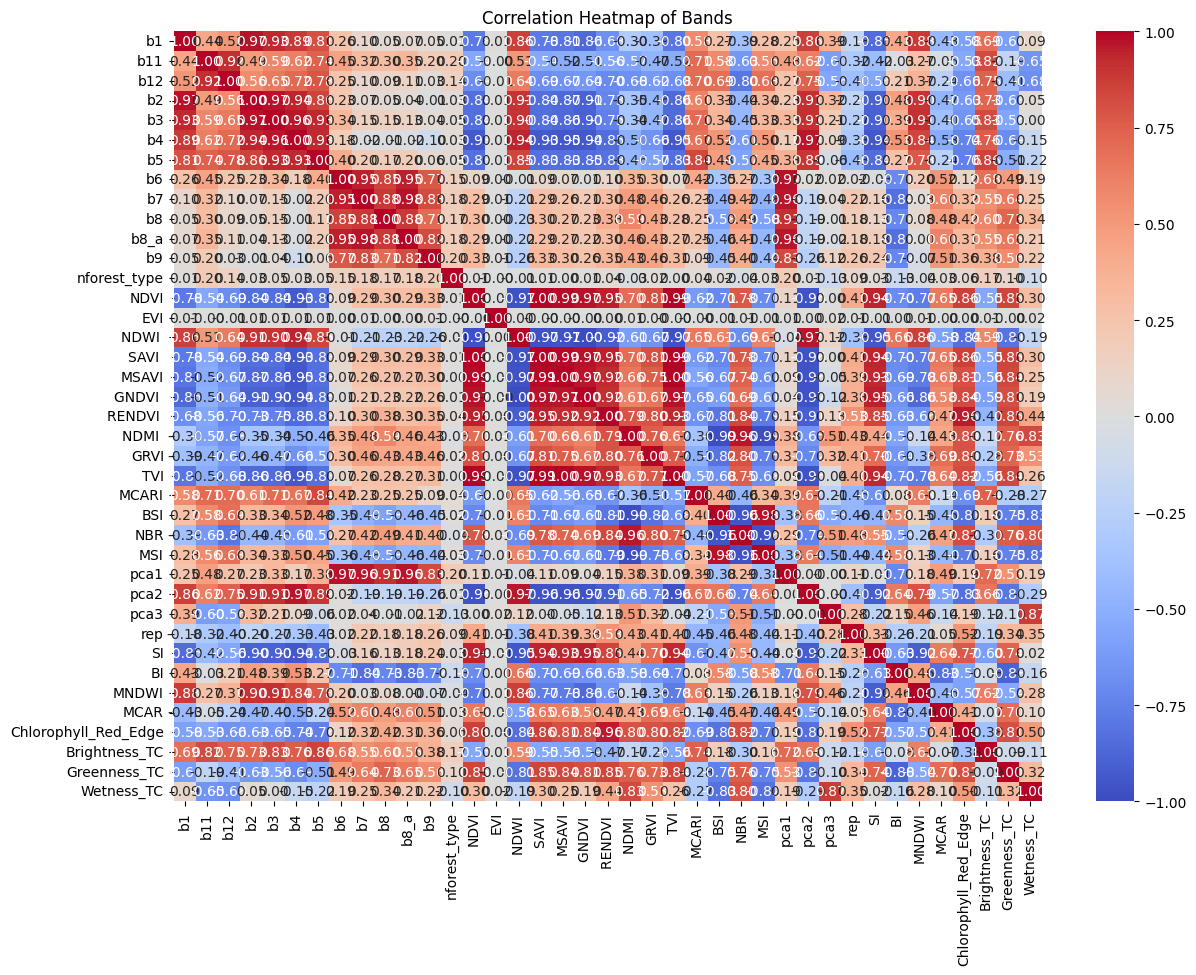

(                 id            b1           b11           b12            b2  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean    8546.088179    352.787482   1785.723742    894.546541    400.200414   
 std     4918.719492    303.240789    336.070954    268.330211    311.052850   
 min        0.000000      0.000000    167.000000     65.000000      1.000000   
 25%     4280.000000    181.000000   1530.000000    697.000000    220.000000   
 50%     8540.000000    244.000000   1774.000000    853.000000    285.000000   
 75%    12798.000000    402.000000   2012.000000   1046.000000    453.000000   
 max    17051.000000   2616.000000   4110.000000   4994.000000   2480.000000   
 
                  b3            b4            b5            b6            b7  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean     578.862560    442.523481    896.518885   2056.567226   2512.113001   
 std      290.515207    293.689997    

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary_stats = train_df_new_num.describe()

# Distribution of forest types
forest_type_distribution = train_df_new_num['nforest_type'].value_counts()

# Correlation analysis
correlation_matrix = train_df_new_num.drop(columns=['id']).corr()

# Plotting the distribution of forest types
plt.figure(figsize=(8, 6))
sns.barplot(x=forest_type_distribution.index, y=forest_type_distribution.values)
plt.title('Distribution of Forest Types')
plt.xlabel('Forest Type')
plt.ylabel('Count')
plt.show()

# Plotting the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Bands')
plt.show()

summary_stats, forest_type_distribution

--------

# Step 1: Initial Training and Hyperparameter Tuning with Optuna

In [15]:
!pip uninstall lightgbm
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!pip install lightgbm

Found existing installation: lightgbm 4.1.0
Uninstalling lightgbm-4.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/lightgbm-4.1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/lightgbm/*
Proceed (Y/n)? y
  Successfully uninstalled lightgbm-4.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.2 MB/s eta 0:00:00


In [16]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 15.8 MB/s eta 0:00:00


In [17]:
!pip install optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.6 MB/s eta 0:00:00


In [18]:
# Assign X, y for splittinf train and val
X = train_df_new_num.drop(['id', 'nforest_type'], axis=1)
y = train_df_new_num['nforest_type']

**OptunaSearchCV:** hyperparameter tuning for each classifier (results compiled into df)

In [19]:
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from imblearn.over_sampling import SMOTE

In [20]:
# Set parameters
VAL_SPLIT = 0.15
CV_NUM = 8
SCALE = MinMaxScaler()
seed = 42

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, stratify=y, random_state=seed)

# Balance the classes using SMOTE
smote = SMOTE(random_state=seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_balanced = imputer.fit_transform(X_train_balanced)
X_val = imputer.transform(X_val)

# Scale the data
X_train = SCALE.fit_transform(X_train_balanced)
X_val = SCALE.transform(X_val)

In [62]:
# Define K-Fold cross-validation
kfold = StratifiedKFold(n_splits=CV_NUM, shuffle=True, random_state=seed)


# Define classifiers and their parameter grids
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'solver': optuna.distributions.CategoricalDistribution(['lbfgs', 'saga'])
    }),
    "KNeighborsClassifier": (KNeighborsClassifier(), {
        'n_neighbors': optuna.distributions.IntDistribution(1, 50),
        'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance'])
    }),
    "DecisionTreeClassifier": (DecisionTreeClassifier(random_state=seed), {
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16)
    }),
    "AdaBoostClassifier": (AdaBoostClassifier(DecisionTreeClassifier(random_state=seed), random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 200),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True)
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 200),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
    }),
    "GradientBoostingClassifier": (GradientBoostingClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 200),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32)
    }),
    "SVC": (SVC(), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid'])
    }),
    "MLPClassifier": (MLPClassifier(random_state=seed), {
        'hidden_layer_sizes': optuna.distributions.CategoricalDistribution([(50,), (100,), (50, 50), (100, 100)]),
        'activation': optuna.distributions.CategoricalDistribution(['relu', 'tanh', 'logistic','identity']),
        'alpha': optuna.distributions.FloatDistribution(1e-4, 1e-2, log=True),
        'learning_rate_init': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_iter': optuna.distributions.IntDistribution(200, 1000)
    }),
    "XGBClassifier": (XGBClassifier(random_state=seed, tree_method='gpu_hist'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_child_weight': optuna.distributions.IntDistribution(1, 10)
    }),
    "LGBMClassifier": (LGBMClassifier(random_state=seed, device='gpu'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'num_leaves': optuna.distributions.IntDistribution(2, 256),
        'boosting_type': optuna.distributions.CategoricalDistribution(['gbdt', 'dart'])
    }),
    "CatBoostClassifier": (CatBoostClassifier(random_state=seed, verbose=0, task_type='GPU'), {
        'iterations': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'depth': optuna.distributions.IntDistribution(1, 16)
    })
}

# Perform hyperparameter tuning using Optuna
optuna_results = []

for name, (classifier, param_grid) in classifiers.items():
    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    optuna_search.fit(X_train, y_train_balanced)
    best_estimator = optuna_search.best_estimator_
    best_params = optuna_search.best_params_
    best_score = optuna_search.best_score_
    print(f'[model: {name}]')
    print("Best Parameters: ", best_params)
    print("Best Estimator: ", best_estimator)
    print("Best Score: ", best_score)
    print('---------------------')
    optuna_results.append((name, best_score, best_params, best_estimator))

# Compile the results
optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

optuna_results_df.to_csv(f'{results_path}/optuna_results_df_feat01.csv', index=False)

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but cont

[model: LogisticRegression]
Best Parameters:  {'C': 30.431445234775072, 'solver': 'lbfgs'}
Best Estimator:  LogisticRegression(C=30.431445234775072, max_iter=1000)
Best Score:  0.6573054451606997
---------------------


[I 2024-06-05 14:53:29,523] Trial 6 finished with value: 0.7341347570693242 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 6 with value: 0.7341347570693242.
[I 2024-06-05 14:53:29,639] Trial 4 finished with value: 0.729186087100826 and parameters: {'n_neighbors': 10, 'weights': 'distance'}. Best is trial 6 with value: 0.7341347570693242.
[I 2024-06-05 14:53:30,173] Trial 2 finished with value: 0.7079251108001934 and parameters: {'n_neighbors': 30, 'weights': 'distance'}. Best is trial 6 with value: 0.7341347570693242.
[I 2024-06-05 14:53:30,303] Trial 0 finished with value: 0.7059852848187284 and parameters: {'n_neighbors': 34, 'weights': 'distance'}. Best is trial 6 with value: 0.7341347570693242.
[I 2024-06-05 14:53:30,404] Trial 7 finished with value: 0.6990310884312867 and parameters: {'n_neighbors': 43, 'weights': 'distance'}. Best is trial 6 with value: 0.7341347570693242.
[I 2024-06-05 14:53:31,828] Trial 8 finished with value: 0.712538304392237 and par

[model: KNeighborsClassifier]
Best Parameters:  {'n_neighbors': 6, 'weights': 'distance'}
Best Estimator:  KNeighborsClassifier(n_neighbors=6, weights='distance')
Best Score:  0.7341347570693242
---------------------


[I 2024-06-05 14:53:45,982] Trial 4 finished with value: 0.6152463641227686 and parameters: {'max_depth': 7, 'min_samples_split': 12}. Best is trial 4 with value: 0.6152463641227686.
[I 2024-06-05 14:53:47,593] Trial 8 finished with value: 0.4808419026446125 and parameters: {'max_depth': 1, 'min_samples_split': 16}. Best is trial 4 with value: 0.6152463641227686.
[I 2024-06-05 14:53:47,871] Trial 0 finished with value: 0.6433299571105255 and parameters: {'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.6433299571105255.
[I 2024-06-05 14:53:48,354] Trial 6 finished with value: 0.639317831320475 and parameters: {'max_depth': 10, 'min_samples_split': 15}. Best is trial 0 with value: 0.6433299571105255.
[I 2024-06-05 14:53:48,609] Trial 1 finished with value: 0.644199942489764 and parameters: {'max_depth': 11, 'min_samples_split': 11}. Best is trial 1 with value: 0.644199942489764.
[I 2024-06-05 14:53:49,665] Trial 3 finished with value: 0.6565693642114661 and parame

[model: DecisionTreeClassifier]
Best Parameters:  {'max_depth': 19, 'min_samples_split': 2}
Best Estimator:  DecisionTreeClassifier(max_depth=19, random_state=42)
Best Score:  0.6575724314240508
---------------------


[I 2024-06-05 14:54:07,487] Trial 4 finished with value: 0.6541626609785895 and parameters: {'n_estimators': 129, 'learning_rate': 0.09138425966643408}. Best is trial 4 with value: 0.6541626609785895.
[I 2024-06-05 14:54:07,717] Trial 2 finished with value: 0.6541626609785895 and parameters: {'n_estimators': 113, 'learning_rate': 0.052627401995611514}. Best is trial 4 with value: 0.6541626609785895.
[I 2024-06-05 14:54:07,890] Trial 5 finished with value: 0.6541626609785895 and parameters: {'n_estimators': 98, 'learning_rate': 0.0015844703858354928}. Best is trial 4 with value: 0.6541626609785895.
[I 2024-06-05 14:54:07,938] Trial 1 finished with value: 0.6541626609785895 and parameters: {'n_estimators': 166, 'learning_rate': 0.0250305598816824}. Best is trial 4 with value: 0.6541626609785895.
[I 2024-06-05 14:54:08,112] Trial 6 finished with value: 0.6541626609785895 and parameters: {'n_estimators': 130, 'learning_rate': 0.004857498827945824}. Best is trial 4 with value: 0.65416266097

[model: AdaBoostClassifier]
Best Parameters:  {'n_estimators': 129, 'learning_rate': 0.09138425966643408}
Best Estimator:  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                   learning_rate=0.09138425966643408, n_estimators=129,
                   random_state=42)
Best Score:  0.6541626609785895
---------------------


[I 2024-06-05 14:55:14,878] Trial 3 finished with value: 0.5937141097501308 and parameters: {'n_estimators': 79, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.5937141097501308.
[I 2024-06-05 14:55:19,949] Trial 5 finished with value: 0.528117033330186 and parameters: {'n_estimators': 151, 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.5937141097501308.
[I 2024-06-05 14:55:37,608] Trial 4 finished with value: 0.6705455675630824 and parameters: {'n_estimators': 75, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.6705455675630824.
[I 2024-06-05 14:55:52,540] Trial 7 finished with value: 0.555799771389659 and parameters: {'n_estimators': 183, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.6705455675630824.
[I 2024-06-05 14:56:02,120] Trial 0 finished with value: 0.7214987782651365 and parameters: {'n_es

[model: RandomForestClassifier]
Best Parameters:  {'n_estimators': 151, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 2}
Best Estimator:  RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=151, random_state=42)
Best Score:  0.751721873631986
---------------------


[I 2024-06-05 14:59:03,062] Trial 7 finished with value: 0.6813775203646321 and parameters: {'n_estimators': 165, 'learning_rate': 0.002292548130643567, 'max_depth': 8}. Best is trial 3 with value: 0.7327991819812706.
[I 2024-06-05 15:16:26,532] Trial 8 finished with value: 0.7330663113049102 and parameters: {'n_estimators': 189, 'learning_rate': 0.05620274944643427, 'max_depth': 5}. Best is trial 8 with value: 0.7330663113049102.
[I 2024-06-05 15:25:42,074] Trial 3 finished with value: 0.6831828696749384 and parameters: {'n_estimators': 82, 'learning_rate': 0.004970253648606498, 'max_depth': 8}. Best is trial 3 with value: 0.6831828696749384.
[I 2024-06-05 15:43:25,396] Trial 0 finished with value: 0.704112196461833 and parameters: {'n_estimators': 53, 'learning_rate': 0.0651048412831291, 'max_depth': 22}. Best is trial 8 with value: 0.7330663113049102.
[I 2024-06-05 15:48:20,228] Trial 5 finished with value: 0.7704435655774057 and parameters: {'n_estimators': 68, 'learning_rate': 0.0

[model: GradientBoostingClassifier]
Best Parameters:  {'n_estimators': 199, 'learning_rate': 0.014276443419840985, 'max_depth': 13}
Best Estimator:  GradientBoostingClassifier(learning_rate=0.014276443419840985, max_depth=13,
                           n_estimators=199, random_state=42)
Best Score:  0.7600798491000077
---------------------


[I 2024-06-05 17:43:17,666] Trial 5 finished with value: 0.6029430362543383 and parameters: {'C': 0.0702203806594082, 'kernel': 'linear'}. Best is trial 5 with value: 0.6029430362543383.
[I 2024-06-05 17:43:45,391] Trial 3 finished with value: 0.4719493108785905 and parameters: {'C': 0.0021438551481812794, 'kernel': 'linear'}. Best is trial 5 with value: 0.6029430362543383.
[I 2024-06-05 17:44:07,152] Trial 0 finished with value: 0.5692414657384915 and parameters: {'C': 0.027568770524705535, 'kernel': 'rbf'}. Best is trial 5 with value: 0.6029430362543383.
[I 2024-06-05 17:44:42,971] Trial 1 finished with value: 0.4498836562204044 and parameters: {'C': 0.001495579237303321, 'kernel': 'rbf'}. Best is trial 5 with value: 0.6029430362543383.
[I 2024-06-05 17:45:14,385] Trial 6 finished with value: 0.35740365604873203 and parameters: {'C': 4.4465705074687625, 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.6029430362543383.
[I 2024-06-05 17:45:38,257] Trial 4 finished with value: 0.333

[model: SVC]
Best Parameters:  {'C': 75.95079576450352, 'kernel': 'poly'}
Best Estimator:  SVC(C=75.95079576450352, kernel='poly')
Best Score:  0.721364659244699
---------------------


[I 2024-06-05 17:55:17,173] Trial 7 finished with value: 0.6280868118442473 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.00022608491351735433, 'learning_rate_init': 0.050966371707753956, 'max_iter': 949}. Best is trial 7 with value: 0.6280868118442473.
[I 2024-06-05 17:55:55,217] Trial 0 finished with value: 0.6381822545156981 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 0.00023272198043449175, 'learning_rate_init': 0.04789050594441721, 'max_iter': 397}. Best is trial 0 with value: 0.6381822545156981.
[I 2024-06-05 17:59:03,347] Trial 3 finished with value: 0.6317624240707519 and parameters: {'hidden_layer_sizes': (100, 100), 'activation': 'identity', 'alpha': 0.0008200466047126254, 'learning_rate_init': 0.00926726051529619, 'max_iter': 241}. Best is trial 0 with value: 0.6381822545156981.
[I 2024-06-05 18:00:18,224] Trial 8 finished with value: 0.4650534473237712 and parameters: {'hidden_layer_sizes': (100, 100), 'acti

[model: MLPClassifier]
Best Parameters:  {'hidden_layer_sizes': (100, 100), 'activation': 'tanh', 'alpha': 0.000528303987239596, 'learning_rate_init': 0.0010032657855312608, 'max_iter': 767}
Best Estimator:  MLPClassifier(activation='tanh', alpha=0.000528303987239596,
              hidden_layer_sizes=(100, 100),
              learning_rate_init=0.0010032657855312608, max_iter=767,
              random_state=42)
Best Score:  0.7279189305957317
---------------------


[I 2024-06-05 18:13:17,333] Trial 4 finished with value: 0.5838175208796491 and parameters: {'n_estimators': 235, 'learning_rate': 0.007086791593094779, 'max_depth': 2, 'min_child_weight': 2}. Best is trial 4 with value: 0.5838175208796491.
[I 2024-06-05 18:14:43,641] Trial 2 finished with value: 0.6355754099392565 and parameters: {'n_estimators': 368, 'learning_rate': 0.0022440570106847272, 'max_depth': 5, 'min_child_weight': 4}. Best is trial 2 with value: 0.6355754099392565.
[I 2024-06-05 18:14:55,808] Trial 5 finished with value: 0.6393864644938669 and parameters: {'n_estimators': 405, 'learning_rate': 0.0022376389104778803, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 5 with value: 0.6393864644938669.
[I 2024-06-05 18:15:23,671] Trial 0 finished with value: 0.7425608649997282 and parameters: {'n_estimators': 238, 'learning_rate': 0.027627787618732677, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 0 with value: 0.7425608649997282.
[I 2024-06-05 18:16:18,138] Trial 

[model: XGBClassifier]
Best Parameters:  {'n_estimators': 476, 'learning_rate': 0.035977130496909406, 'max_depth': 9, 'min_child_weight': 9}
Best Estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.035977130496909406,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=476, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best Score:  0.7683707292927385
---------------------


[I 2024-06-05 18:22:44,301] Trial 4 finished with value: 0.6134407644569575 and parameters: {'n_estimators': 107, 'learning_rate': 0.005560559278073722, 'num_leaves': 9, 'boosting_type': 'gbdt'}. Best is trial 4 with value: 0.6134407644569575.
[I 2024-06-05 18:23:49,961] Trial 7 finished with value: 0.643329814050237 and parameters: {'n_estimators': 62, 'learning_rate': 0.001082341243322481, 'num_leaves': 51, 'boosting_type': 'gbdt'}. Best is trial 7 with value: 0.643329814050237.
[I 2024-06-05 18:25:06,006] Trial 0 finished with value: 0.6506184496270419 and parameters: {'n_estimators': 86, 'learning_rate': 0.001052354244083966, 'num_leaves': 66, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.6506184496270419.
[I 2024-06-05 18:29:01,574] Trial 5 finished with value: 0.7445675716660515 and parameters: {'n_estimators': 123, 'learning_rate': 0.02064637565243947, 'num_leaves': 124, 'boosting_type': 'gbdt'}. Best is trial 5 with value: 0.7445675716660515.
[I 2024-06-05 18:31:49,59

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 14955, number of used features: 38
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (0.57 MB) transferred to GPU in 0.001474 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


<ipython-input-62-7523f86c4293>:90: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-05 18:41:27,648] A new study created in memory with name: no-name-5066b2d1-8595-4e3b-ad36-8b9e36c272fd


[model: LGBMClassifier]
Best Parameters:  {'n_estimators': 276, 'learning_rate': 0.07851776075445864, 'num_leaves': 219, 'boosting_type': 'gbdt'}
Best Estimator:  LGBMClassifier(device='gpu', learning_rate=0.07851776075445864,
               n_estimators=276, num_leaves=219, random_state=42)
Best Score:  0.7981263036368786
---------------------


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
[W 2024-06-05 18:41:35,039] Trial 5 failed with parameters: {'iterations': 171, 'learning_rate': 0.04481162540971456, 'depth': 14} because of the following error: The value nan is not acceptable.
[W 2024-06-05 18:41:35,047] Trial 5 failed with value nan.
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 18:41:35,438] Trial 1 failed with parameters: {'iterations': 307, 'learning_rate': 0.004607767277854624, 'depth': 7} because of the following error: The value nan is not acceptable.
/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/l

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 302, 'learning_rate': 0.006379795091939305, 'depth': 15}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7e8943104c10>
Best Score:  0.6825147065976543
---------------------
                         Model  Best Score  \
0           LogisticRegression    0.657305   
1         KNeighborsClassifier    0.734135   
2       DecisionTreeClassifier    0.657572   
3           AdaBoostClassifier    0.654163   
4       RandomForestClassifier    0.751722   
5   GradientBoostingClassifier    0.760080   
6                          SVC    0.721365   
7                MLPClassifier    0.727919   
8                XGBClassifier    0.768371   
9               LGBMClassifier    0.798126   
10          CatBoostClassifier    0.682515   

                                      Best Parameters  \
0        {'C': 30.431445234775072, 'solver': 'lbfgs'}   
1           {'n_neighbors': 6, 'weights': 'distance'}   
2           {'max_depth': 1

In [63]:
optuna_results

[('LogisticRegression',
  0.6573054451606997,
  {'C': 30.431445234775072, 'solver': 'lbfgs'},
  LogisticRegression(C=30.431445234775072, max_iter=1000)),
 ('KNeighborsClassifier',
  0.7341347570693242,
  {'n_neighbors': 6, 'weights': 'distance'},
  KNeighborsClassifier(n_neighbors=6, weights='distance')),
 ('DecisionTreeClassifier',
  0.6575724314240508,
  {'max_depth': 19, 'min_samples_split': 2},
  DecisionTreeClassifier(max_depth=19, random_state=42)),
 ('AdaBoostClassifier',
  0.6541626609785895,
  {'n_estimators': 129, 'learning_rate': 0.09138425966643408},
  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                     learning_rate=0.09138425966643408, n_estimators=129,
                     random_state=42)),
 ('RandomForestClassifier',
  0.751721873631986,
  {'n_estimators': 151,
   'max_depth': 25,
   'min_samples_split': 8,
   'min_samples_leaf': 2},
  RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=8,
                  

### *** if error occurred during hyperparams tuning

In [ ]:
###for error debugging
optuna_results_df_err = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
optuna_results_df_err.to_csv(f'{results_path}/optuna_results_df_feat01-not-finished.csv', index=False)

In [ ]:
optuna_results_df_err['Model']

0            LogisticRegression
1          KNeighborsClassifier
2        DecisionTreeClassifier
3            AdaBoostClassifier
4        RandomForestClassifier
5    GradientBoostingClassifier
6                           SVC
7                 MLPClassifier
8                 XGBClassifier
Name: Model, dtype: object

In [ ]:
# Perform hyperparameter tuning using Optuna
optuna_results = []

# Skip models that have already been trained
trained_models = optuna_results_df_err['Model'].tolist()

for name, (classifier, param_grid) in classifiers.items():
    if name in trained_models:
        print(f'Skipping already trained model: {name}')
        continue

    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    try:
        optuna_search.fit(X_train, y_train_balanced)
        best_estimator = optuna_search.best_estimator_
        best_params = optuna_search.best_params_
        best_score = optuna_search.best_score_
        print(f'[model: {name}]')
        print("Best Parameters: ", best_params)
        print("Best Estimator: ", best_estimator)
        print("Best Score: ", best_score)
        print('---------------------')
        optuna_results.append((name, best_score, best_params))
    except Exception as e:
        print(f'Error training model {name}: {e}')

# Compile the results
new_optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters"])

# Combine with previous results
combined_optuna_results_df = pd.concat([optuna_results_df, new_optuna_results_df], ignore_index=True)
print(combined_optuna_results_df)

# Save the combined results
combined_optuna_results_df.to_csv(f'{results_path}/combined_optuna_results_df_feat01.csv', index=False)
print(f"Combined results saved to: {results_path}/combined_optuna_results_df_feat01.csv")

<ipython-input-20-cebc5fe5e400>:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-05 09:07:08,020] A new study created in memory with name: no-name-344aaf52-d57c-447e-8ce0-ebbc2191f1c2


Skipping already trained model: LogisticRegression
Skipping already trained model: KNeighborsClassifier
Skipping already trained model: DecisionTreeClassifier
Skipping already trained model: AdaBoostClassifier
Skipping already trained model: RandomForestClassifier
Skipping already trained model: GradientBoostingClassifier
Skipping already trained model: SVC
Skipping already trained model: MLPClassifier
Skipping already trained model: XGBClassifier


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:08,974] Trial 5 failed with parameters: {'n_estimators': 79, 'learning_rate': 0.19188234555422495, 'num_leaves': 23, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,978] Trial 5 failed with value nan.
[W 2024-06-05 09:07:08,988] Trial 3 failed with parameters: {'n_estimators': 184, 'learning_rate': 0.13362042989298442, 'num_leaves': 93, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,992] Trial 3 failed with value nan.
[W 2024-06-05 09:07:08,994] Trial 2 failed with parameters: {'n_es

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 14976, number of used features: 29
Error training model LGBMClassifier: No OpenCL device found


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,398] Trial 1 failed with parameters: {'iterations': 59, 'learning_rate': 0.404665400351513, 'depth': 9} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:14,406] Trial 1 failed with value nan.
/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,614]

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 150, 'learning_rate': 0.0151103585762203, 'depth': 13}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7c54703bffa0>
Best Score:  0.6694043803418803
---------------------
                        Model  Best Score  \
0          LogisticRegression    0.647903   
1        KNeighborsClassifier    0.732505   
2      DecisionTreeClassifier    0.653846   
3          AdaBoostClassifier    0.655115   
4      RandomForestClassifier    0.765425   
5  GradientBoostingClassifier    0.781317   
6                         SVC    0.685029   
7               MLPClassifier    0.691306   
8               XGBClassifier    0.778646   
9          CatBoostClassifier    0.669404   

                                     Best Parameters  
0        {'C': 8.490782592210358, 'solver': 'lbfgs'}  
1          {'n_neighbors': 9, 'weights': 'distance'}  
2          {'max_depth': 31, 'min_samples_split': 2}  
3  {'n_estimators': 180, 'learning_ra

In [ ]:
combined_optuna_results_df

,Model,Best Score,Best Parameters
0,LogisticRegression,0.647903,"{'C': 8.490782592210358, 'solver': 'lbfgs'}"
1,KNeighborsClassifier,0.732505,"{'n_neighbors': 9, 'weights': 'distance'}"
2,DecisionTreeClassifier,0.653846,"{'max_depth': 31, 'min_samples_split': 2}"
3,AdaBoostClassifier,0.655115,"{'n_estimators': 180, 'learning_rate': 0.02880..."
4,RandomForestClassifier,0.765425,"{'n_estimators': 130, 'max_depth': 21, 'min_sa..."
5,GradientBoostingClassifier,0.781317,"{'n_estimators': 154, 'learning_rate': 0.11829..."
6,SVC,0.685029,"{'C': 4.61538732142158, 'kernel': 'rbf'}"
7,MLPClassifier,0.691306,"{'hidden_layer_sizes': (100, 100), 'activation..."
8,XGBClassifier,0.778646,"{'n_estimators': 106, 'learning_rate': 0.09181..."
9,CatBoostClassifier,0.669404,"{'iterations': 150, 'learning_rate': 0.0151103..."


In [ ]:
optuna_results_df = combined_optuna_results_df.copy()

---------------------------

------------------------------
# Step 2: Select Top Models
## (Include MLPClassifier in the top models)

In [21]:
optuna_results_df = pd.read_csv('/content/results/multmodels_optuna/features01-wvote-feat02/optuna_results_df_feat02.csv')

In [22]:
# Compile the results
# optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

# Select top models based on validation accuracy
top_6_models = optuna_results_df.sort_values(by='Best Score', ascending=False).head(6)
top_6_models

                         Model  Best Score  \
0           LogisticRegression    0.657305   
1         KNeighborsClassifier    0.734135   
2       DecisionTreeClassifier    0.657572   
3           AdaBoostClassifier    0.654163   
4       RandomForestClassifier    0.751722   
5   GradientBoostingClassifier    0.760080   
6                          SVC    0.721365   
7                MLPClassifier    0.727919   
8                XGBClassifier    0.768371   
9               LGBMClassifier    0.798126   
10          CatBoostClassifier    0.682515   

                                      Best Parameters  \
0        {'C': 30.431445234775072, 'solver': 'lbfgs'}   
1           {'n_neighbors': 6, 'weights': 'distance'}   
2           {'max_depth': 19, 'min_samples_split': 2}   
3   {'n_estimators': 129, 'learning_rate': 0.09138...   
4   {'n_estimators': 151, 'max_depth': 25, 'min_sa...   
5   {'n_estimators': 199, 'learning_rate': 0.01427...   
6          {'C': 75.95079576450352, 'kernel': 'p

,Model,Best Score,Best Parameters,Best Estimator
9,LGBMClassifier,0.798126,"{'n_estimators': 276,\n 'learning_rate': 0.0...","LGBMClassifier(device='gpu', learning_rate=0.0..."
8,XGBClassifier,0.768371,"{'n_estimators': 476,\n 'learning_rate': 0.0...","XGBClassifier(base_score=None, booster=None, c..."
5,GradientBoostingClassifier,0.760080,"{'n_estimators': 199, 'learning_rate': 0.01427...",GradientBoostingClassifier(learning_rate=0.014...
4,RandomForestClassifier,0.751722,"{'n_estimators': 151, 'max_depth': 25, 'min_sa...","RandomForestClassifier(max_depth=25, min_sampl..."
1,KNeighborsClassifier,0.734135,"{'n_neighbors': 6, 'weights': 'distance'}","KNeighborsClassifier(n_neighbors=6, weights='d..."
7,MLPClassifier,0.727919,"{'hidden_layer_sizes': (100, 100), 'activation...","MLPClassifier(activation='tanh', alpha=0.00052..."


# Step 3: Predictions

## Retrain each top model(full training data)

In [23]:
import numpy as np
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train_balanced, y_val])
print(X_combined.shape, y_combined.shape)

(16913, 38) (16913,)


In [24]:
retrained_models = []
for index, row in top_6_models.iterrows():
    model_name = row['Model']
    best_estimator = row['Best Estimator']
    best_params = row['Best Parameters']

    # Ensure best_params is a dictionary
    if isinstance(best_params, str):
        best_params = eval(best_params)  # Convert string representation of dictionary to actual dictionary
    if isinstance(best_estimator, str):
        best_estimator = globals()[model_name](**best_params)

    # best_estimator.fit(X_train, y_train_balanced)
    best_estimator.fit(X_combined, y_combined)
    retrained_models.append((model_name, best_estimator))

# Evaluate fine-tuned models on the validation set
retrained_models_acc = []
for model_name, model in retrained_models:
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    retrained_models_acc.append((model_name, accuracy))
    print(f'Validation Accuracy for {model_name}: {accuracy}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 16913, number of used features: 38
[LightGBM] [Info] Start training from score -1.092012
[LightGBM] [Info] Start training from score -1.146696
[LightGBM] [Info] Start training from score -1.059080
Validation Accuracy for LGBMClassifier: 1.0
Validation Accuracy for XGBClassifier: 0.9305413687436159
Validation Accuracy for GradientBoostingClassifier: 1.0
Validation Accuracy for RandomForestClassifier: 0.9708886618998979
Validation Accuracy for KNeighborsClassifier: 1.0
Validation Accuracy for MLPClassifier: 0.7288049029622063


In [25]:
sorted_retrained_models_acc = sorted(retrained_models_acc, key=lambda x: x[1], reverse=True)
print(sorted_retrained_models_acc)
retrained_models_dict = dict(retrained_models)
sorted_retrained_models = [(model_name, retrained_models_dict[model_name]) for model_name, _ in sorted_retrained_models_acc]
print(sorted_retrained_models)

[('LGBMClassifier', 1.0), ('GradientBoostingClassifier', 1.0), ('KNeighborsClassifier', 1.0), ('RandomForestClassifier', 0.9708886618998979), ('XGBClassifier', 0.9305413687436159), ('MLPClassifier', 0.7288049029622063)]
[('LGBMClassifier', LGBMClassifier(learning_rate=0.07851776075445864, n_estimators=276,
               num_leaves=219)), ('GradientBoostingClassifier', GradientBoostingClassifier(learning_rate=0.014276443419840985, max_depth=13,
                           n_estimators=199)), ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=6, weights='distance')), ('RandomForestClassifier', RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=151)), ('XGBClassifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=Non

In [26]:
retrained_models_dict

{'LGBMClassifier': LGBMClassifier(learning_rate=0.07851776075445864, n_estimators=276,
                num_leaves=219),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.035977130496909406,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=9, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=476, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...),
 'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.0

In [29]:
# List of model names in the preferred order
model_order = list(retrained_models_dict.keys())
top_6_models['Model'] = pd.Categorical(top_6_models['Model'], categories=model_order, ordered=True)
sorted_top_6_models = top_6_models.sort_values('Model')
print(sorted_top_6_models)

                        Model  Best Score  \
9              LGBMClassifier    0.798126   
8               XGBClassifier    0.768371   
5  GradientBoostingClassifier    0.760080   
4      RandomForestClassifier    0.751722   
1        KNeighborsClassifier    0.734135   
7               MLPClassifier    0.727919   

                                     Best Parameters  \
9  {'n_estimators': 276,\n   'learning_rate': 0.0...   
8  {'n_estimators': 476,\n   'learning_rate': 0.0...   
5  {'n_estimators': 199, 'learning_rate': 0.01427...   
4  {'n_estimators': 151, 'max_depth': 25, 'min_sa...   
1          {'n_neighbors': 6, 'weights': 'distance'}   
7  {'hidden_layer_sizes': (100, 100), 'activation...   

                                      Best Estimator  
9  LGBMClassifier(device='gpu', learning_rate=0.0...  
8  XGBClassifier(base_score=None, booster=None, c...  
5  GradientBoostingClassifier(learning_rate=0.014...  
4  RandomForestClassifier(max_depth=25, min_sampl...  
1  KNeighborsCla

## Voting Classifier

In [27]:
# Custom Voting Classifier Implementation
test_ids = test_df_new['id']
test_features = test_df_new.drop(columns=['id'])
# Ensure that feature names match those used during fitting
test_features.columns = test_features.columns.astype(str)
# Impute missing values in test data
test_features = SCALE.transform(test_features)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [30]:
# Calculate weights for the top 3 models
weights_top_3 = sorted_top_6_models['Best Score'].head(3).tolist()

# Calculate weights for the top 5 models
weights_top_5 = sorted_top_6_models['Best Score'].head(5).tolist()

# Output the weights
print("Weights for Top 3 models:", weights_top_3)
print("Weights for Top 5 models:", weights_top_5)

Weights for Top 3 models: [0.798126304, 0.768370729, 0.760079849]
Weights for Top 5 models: [0.798126304, 0.768370729, 0.760079849, 0.751721874, 0.734134757]


In [31]:
# Predict with each of the top models
def predict_with_models(models, test_features):
    predictions = []
    for model_name, model in models:
        predictions.append(model.predict(test_features))
    return np.array(predictions).T

# Weighted voting function
def weighted_voting(predictions, weights):
    final_predictions_encoded = []
    for instance_predictions in predictions:
        weighted_votes = np.zeros(len(weights))  # Assuming there are 3 classes
        for i, vote in enumerate(instance_predictions):
            weighted_votes[vote] += weights[i]
        final_predictions_encoded.append(np.argmax(weighted_votes))
    return final_predictions_encoded

# Perform predictions and voting for top 3, top 5, and the best model
top_3_models = retrained_models[:3]
top_5_models = retrained_models[:5]
best_model = retrained_models[0]

# Predict and vote
predictions_top_3 = predict_with_models(top_3_models, test_features)
predictions_top_5 = predict_with_models(top_5_models, test_features)
predictions_best = best_model[1].predict(test_features)  # Best model directly

# Weighted voting
final_predictions_top_3 = weighted_voting(predictions_top_3, weights_top_3)
final_predictions_top_5 = weighted_voting(predictions_top_5, weights_top_5)

# Map the encoded predictions back to the original labels
label_mapping = {'DDF': 0, 'DEF': 1, 'MDF': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
final_predictions_top_3 = [inverse_label_mapping[pred] for pred in final_predictions_top_3]
final_predictions_top_5 = [inverse_label_mapping[pred] for pred in final_predictions_top_5]
final_predictions_best = [inverse_label_mapping[pred] for pred in predictions_best]

# Prepare submission DataFrames
submission_top_3 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_3
})
submission_top_5 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_5
})
submission_best = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_best
})

# Save submission files
submission_top_3_file_path = f'{results_path}/pim-feat02_optuna_top_3_submission.csv'
submission_top_5_file_path = f'{results_path}/pim-feat02_optuna_top_5_submission.csv'
submission_best_file_path = f'{results_path}/pim-feat02_optuna_best_submission.csv'

submission_top_3.to_csv(submission_top_3_file_path, index=False)
submission_top_5.to_csv(submission_top_5_file_path, index=False)
submission_best.to_csv(submission_best_file_path, index=False)

print(f"Submission files saved at:\n{submission_top_3_file_path}\n{submission_top_5_file_path}\n{submission_best_file_path}")

Submission files saved at:
/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_top_3_submission.csv
/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_top_5_submission.csv
/content/results/multmodels_optuna/features01-wvote-feat02/pim-feat02_optuna_best_submission.csv


## Prepare submissions

In [ ]:
# Map the encoded predictions back to the original labels
label_mapping = {'DDF': 0, 'DEF': 1, 'MDF': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
final_predictions_top_3 = [inverse_label_mapping[pred] for pred in final_predictions_top_3]
final_predictions_top_5 = [inverse_label_mapping[pred] for pred in final_predictions_top_5]
final_predictions_best = [inverse_label_mapping[pred] for pred in predictions_best]

# Prepare submission DataFrames
submission_top_3 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_3
})
submission_top_5 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_5
})
submission_best = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_best
})

# Save submission files
submission_top_3_file_path = '/content/pim_optuna_top_3_submission.csv'
submission_top_5_file_path = '/content/pim_optuna_top_5_submission.csv'
submission_best_file_path = '/content/pim_optuna_best_submission.csv'

submission_top_3.to_csv(submission_top_3_file_path, index=False)
submission_top_5.to_csv(submission_top_5_file_path, index=False)
submission_best.to_csv(submission_best_file_path, index=False)

print(f"Submission files saved at:\n{submission_top_3_file_path}\n{submission_top_5_file_path}\n{submission_best_file_path}")

--------------------------

------------------

-----

# Check similarity between two results

Training results should have classes Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}
- DDF(0): 1488
- DEF(1): 1000
- MDF(2): 1512
(Total: 4000)

------------------
------------------
### Results record
**submission_majority_voting_1.csv**
- score acc 0.65615
- Number of DDF: 1400, DEF:831, MDF:1769

.........................

**submission_majority_voting_2.csv**
```
Raw Data
Split 0.15, cv_num = 8 for girdsearchCV  
เปิดtrain+SMOTE ให้เห็นหมดตอน Majority vote
```
- score acc 0.66480
- Number of DDF: 1402, DEF:848, MDF:1750

.........................

**submission_majority_voting_prepdat01.csv**
```
prepdata select features: ['b2', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'NDVI', 'Moisture_Index', 'natural_color', 'false_color', 'vegetation_analysis', 'swir']
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

```
- score: 0.62767
- Number of DDF: 1384, DEF:827, MDF:1789

.........................

**submission_majority_voting_prepdat02.csv**
```
prepdata 18 features
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.66429
- Number of DDF: 1434, DEF:856, MDF:1710

.........................


**submission_3voting_prepfeats.csv**
```
data with 29 features (jane's features no drop)
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.67293
- Number of DDF: 1420, DEF:835, MDF:1745

.........................


------------------
------------------